<h1><b>Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import keras

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
print(f"X_train Shape: {X_train.shape}\ny_train shape: {y_train.shape}\n\nX_test Shape: {X_test.shape}\ny_test Shape: {y_test.shape}")

X_train Shape: (60000, 28, 28)
y_train shape: (60000,)

X_test Shape: (10000, 28, 28)
y_test Shape: (10000,)


In [ ]:
X_train[0].shape

(28, 28)

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

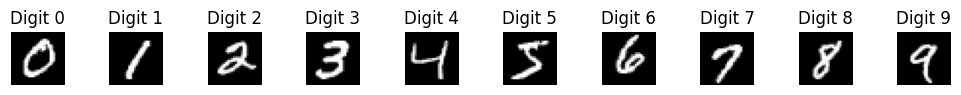

In [ ]:
import matplotlib.pyplot as plt, numpy as np
plt.figure(figsize=(10, 1))

for i in range(10):
    idx = np.where(y_train==i)[0][0]

    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f'Digit {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

<h1><b>Defining Models

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Input, Embedding, Flatten, multiply
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
import numpy as np

In [ ]:
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, LeakyReLU, Dropout, multiply
import numpy as np

In [ ]:
def build_discriminator():
    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])

    output = model(model_input)

    return Model([img, label], output)

In [ ]:
from keras.optimizers import Adam

img_shape = (28, 28, 1)
num_classes = 10
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

In [ ]:
generator = build_generator()
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 100)               1000      ['input_8[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten_3 (Flatten)         (None, 100)                  0         ['embedding_2[0][0]']         
                                                                                            

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 784)               7840      ['input_10[0][0]']            
                                                                                                  
 flatten_5 (Flatten)         (None, 784)                  0         ['input_9[0][0]']             
                                                                                            

In [ ]:
# The generator takes noise and the target label as input
# and generates the corresponding digit of that label
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
# and the label of that image
valid = discriminator([img, label])

# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator
combined = Model([noise, label], valid)
# Compile the combined model, explicitly specifying the trainable variables
combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

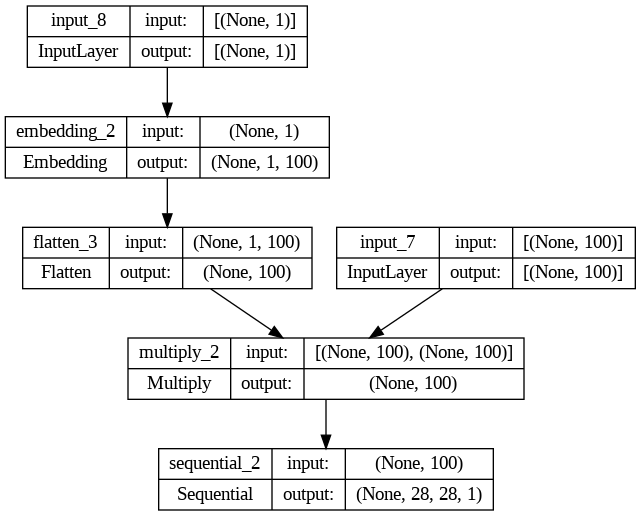

In [ ]:
from keras.utils import plot_model
plot_model(generator,
           show_shapes=True)

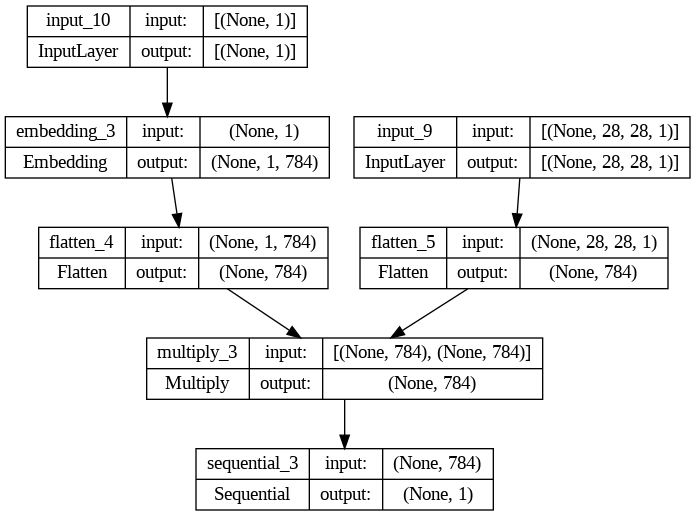

In [ ]:
plot_model(discriminator,
           show_shapes=True,
           show_layer_activations=True)

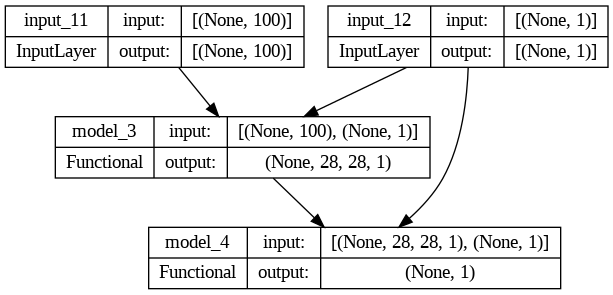

In [ ]:
plot_model(combined,
           show_shapes=True,
           show_layer_activations=True)

<h1><b>Training CGAN

In [ ]:
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/drive/MyDrive/prescient/Conditional GAN/new_output2/%d.png" % epoch)
    plt.close()

In [ ]:
from tensorflow.keras.optimizers import Adam

# Define the optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

optimizer.build(combined.trainable_variables)

# Compile the combined model
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
epochs=15000
batch_size=32
sample_interval=200

# Training both Discriminator and Generator

# Configure input
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
y_train = y_train.reshape(-1, 1)

In [ ]:
import numpy as np

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Declaring empty lists to save the losses for plotting
d_loss_plot = []
g_loss_plot = []
acc_plot = []
real_probabilities_plot = []
fake_probabilities_plot = []

for epoch in range(epochs):

    #Training the Discriminator

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # Sample noise as generator input
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Generate a half batch of new images
    gen_imgs = generator.predict([noise, labels])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #Training the Generator

    # Condition on labels
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], valid)

    # Saving the Discriminator and Generator losses and accuracy for plotting
    d_loss_plot.append(d_loss[0])
    g_loss_plot.append(g_loss)
    acc_plot.append(d_loss[1])
    # Get discriminator output probabilities
    probs_real = d_loss_real[0]
    probs_fake = d_loss_fake[0]
    real_probabilities_plot.append(probs_real)
    fake_probabilities_plot.append(probs_fake)

    # Plot the progress every 100 epochs
    if epoch % 100 == 0:
        print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss))

    # Saving generated image samples at every sample interval
    if epoch % sample_interval == 0:
        sample_images(epoch)


1/1 [==============================] - 0s 154ms/step


0/15000 [D loss: 0.698636, acc.: 9.38%] [G loss: 0.688407]
1/1 [==============================] - 0s 139ms/step


<ipython-input-83-b6bff41dbb8f>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
10100/15000 [D loss: 0.631270, acc.: 62.50%] [G loss: 0.971841]
1/1 [==============================] - 0s 17ms/step
10200/15000 [D loss: 0.682772, acc.: 53.12%] [G loss: 1.084302]
1/1 [==============================] - 0s 17ms/step
10300/15000 [D loss: 0.593635, acc.: 57.81%] [G loss: 1.079343]
1/1 [==============================] - 0s 16ms/step
10400/15000 [D loss: 0.564635, acc.: 67.19%] [G loss: 1.156151]
1/1 [==============================] - 0s 17ms/step
10500/15000 [D loss: 0.645175, acc.: 60.94%] [G loss: 1.236868]
1/1 [==============================] - 0s 16ms/step
10600/15000 [D loss: 0.580332, acc.: 70.31%] [G loss: 1.018819]
1/1 [==============================] - 0s 18ms/step
10700/15000 [D loss: 0.458665, acc.: 79.69%] [G loss: 1.221000]
1/1 [==============================] - 0s 19ms/step
10800/15000 [D loss: 0.665464, acc.: 62.50%] [G loss: 1.193861]
1/1 [================

In [ ]:
copy_real_prob = real_probabilities_plot
copy_fake_prob = fake_probabilities_plot

In [5]:
fake_prob = [0.6962358951568604, 0.695895791053772, 0.6959034204483032, 0.6961480379104614, 0.696255087852478, 0.6969144344329834, 0.6971908211708069, 0.6979699730873108, 0.6983365416526794, 0.6989809274673462, 0.699577808380127, 0.6992672681808472, 0.7012791037559509, 0.701461136341095, 0.7023441195487976, 0.7043329477310181, 0.7002512216567993, 0.6988345384597778, 0.7078244686126709, 0.700203537940979, 0.7020586133003235, 0.6934049129486084, 0.6804256439208984, 0.6875560879707336, 0.6713204979896545, 0.6538543105125427, 0.6517139673233032, 0.6420271396636963, 0.617222785949707, 0.5797343850135803, 0.5701876878738403, 0.524022102355957, 0.5037738680839539, 0.4719991683959961, 0.4269804358482361, 0.37311694025993347, 0.3512466251850128, 0.3451040983200073, 0.27494311332702637, 0.2615814208984375, 0.2280099093914032, 0.19358080625534058, 0.1940554678440094, 0.21636375784873962, 0.19498935341835022, 0.17689016461372375, 0.17948085069656372, 0.1605375111103058, 0.14402981102466583, 0.11983814835548401, 0.12309737503528595, 0.10354682058095932, 0.11748258769512177, 0.09079530835151672, 0.12970496714115143, 0.12343741208314896, 0.1409243941307068, 0.12677818536758423, 0.09811176359653473, 0.0677020400762558, 0.06295477598905563, 0.07337015867233276, 0.06516002118587494, 0.05966217815876007, 0.06525343656539917, 0.058588698506355286, 0.04387405514717102, 0.046628281474113464, 0.03136521577835083, 0.03970140218734741, 0.04066954180598259, 0.035289566963911057, 0.02930322475731373, 0.03175065666437149, 0.025443382561206818, 0.022556383162736893, 0.023151537403464317, 0.020905690267682076, 0.017097625881433487, 0.023235328495502472, 0.030400315299630165, 0.014967089518904686, 0.01139108557254076, 0.019976727664470673, 0.015170104801654816, 0.011776834726333618, 0.009731229394674301, 0.01519419439136982, 0.016177240759134293, 0.016681941226124763, 0.010354189202189445, 0.013729376718401909, 0.009367387741804123, 0.010068252682685852, 0.008838357403874397, 0.01785924658179283, 0.0369715690612793, 0.010681171901524067, 0.014812685549259186, 0.08971162140369415, 0.03166508674621582, 0.03393418341875076, 0.03916837275028229, 0.010767219588160515, 0.00900210440158844, 0.006549346260726452, 0.005832659546285868, 0.005591490771621466, 0.00743569852784276, 0.014230987057089806, 0.009542942978441715, 0.015738338232040405, 0.010414568707346916, 0.03129513934254646, 0.010902449488639832, 0.006194950547069311, 0.0234086737036705, 0.006957558915019035, 0.007418057881295681, 0.01182306744158268, 0.025480033829808235, 0.1357966512441635, 0.11481461673974991, 0.005865886807441711, 0.020200688391923904, 0.1599726676940918, 0.005653525236994028, 0.018107332289218903, 0.9653012752532959, 0.33797019720077515, 0.025760352611541748]
real_prob = [0.7010365724563599, 0.6752387285232544, 0.667151689529419, 0.644334614276886, 0.6324521899223328, 0.6038992404937744, 0.5803675055503845, 0.5550503730773926, 0.5050926804542542, 0.4810580909252167, 0.4356866180896759, 0.37793630361557007, 0.32421162724494934, 0.2586224377155304, 0.2153473198413849, 0.1781279444694519, 0.12318693101406097, 0.09708679467439651, 0.07930164784193039, 0.0676431804895401, 0.053522452]


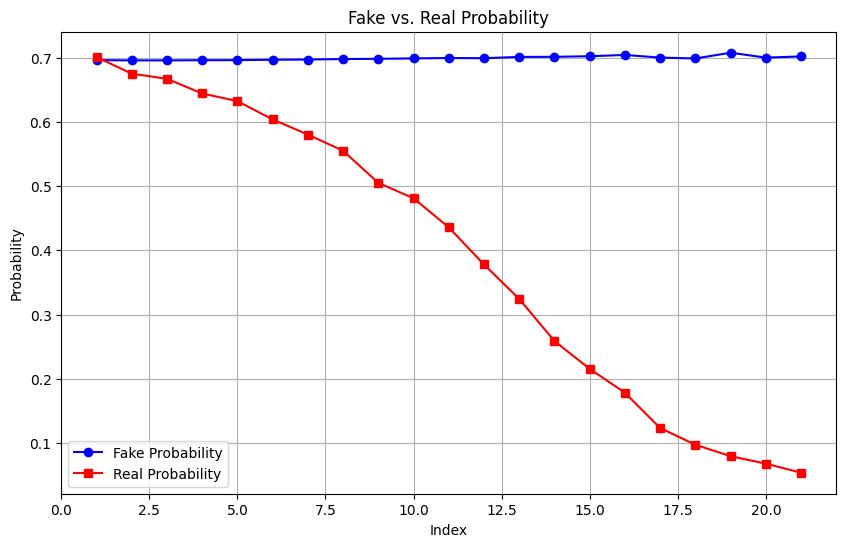

In [7]:
import matplotlib.pyplot as plt

# Extracting the first 21 entries from both lists
fake_prob_21 = fake_prob[:21]
real_prob_21 = real_prob[:21]

# Creating indices for the x-axis
indices = range(1, 22)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(indices, fake_prob_21, label='Fake Probability', color='blue', marker='o')
plt.plot(indices, real_prob_21, label='Real Probability', color='red', marker='s')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.title('Fake vs. Real Probability')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(d_loss_plot)

In [ ]:
print(g_loss_plot)

In [ ]:
print(acc_plot)

In [ ]:
len(real_probabilities_plot)

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Assuming d_loss_plot and g_loss_plot contain data for 20000 iterations
x = np.arange(0, 20000, 200)

plt.figure(figsize=(15, 3))
plt.plot(x, d_loss_plot, marker='o', linestyle='-', color='blue', label='Discriminator Loss')
plt.plot(x, g_loss_plot, marker="*", linestyle='--', color='red', label='Generator Loss')

plt.xlabel('Iteration')
plt.ylabel('Metric')
plt.title('Evaluation of GAN on MNIST', fontweight='bold')
plt.legend()
plt.grid(True)

plt.show()


<h1><b> Load and Predict Image Using Generator

In [ ]:
generator.save('/content/drive/MyDrive/prescient/Conditional GAN/cgan model/generator_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf

In [ ]:
generator = tf.keras.models.load_model('/content/drive/MyDrive/prescient/Conditional GAN/cgan model/generator_model2.h5')

In [ ]:
# type(generator)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_digit(generator, digit_label):

    noise = np.random.normal(0, 1, (1, latent_dim))
    label = np.array([digit_label]).reshape(-1, 1)

    generated_image = generator.predict([noise, label])

    return generated_image[0]

In [ ]:
def display(img):
  # img = np.where(generated_image>0, 1, 0)
  plt.figure(figsize=(2, 2))
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.title(f'Generated MNIST Digit: {to_generate}')
  plt.show()

In [ ]:
latent_dim = 100

1/1 [==============================] - 0s 18ms/step


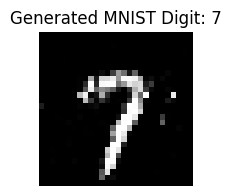

In [ ]:
to_generate = 7

generated_image = generate_digit(generator, to_generate)

display(generated_image)

In [ ]:
generated_image.min()

-1.0